In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import magpylib as magpy
import matplotlib.pyplot as plt
import numpy as np
import torch
from magpylib_material_response import meshing, demag
from nn_magnetics.predictions import B
from nn_magnetics.utils import relative_amplitude_error, angle_error, demagnetizing_factor
from nn_magnetics.models.networks import AngleAmpCorrectionNetwork
from nn_magnetics.data import AnisotropicData, simulate_demag

Meshing magnet and applying demag effects
2025-02-19 at 19:24:19 |   INFO   | run | {} ℹ️ Start Demagnetization of Collection_01 with 100 cells - Counter({'Cuboid': 100})
2025-02-19 at 19:24:20 | SUCCESS  | timelog | {} ✅  Demagnetization of Collection_01 with 100 cells - Counter({'Cuboid': 100}) done 🕑 1.022sec
Creating measurement grid


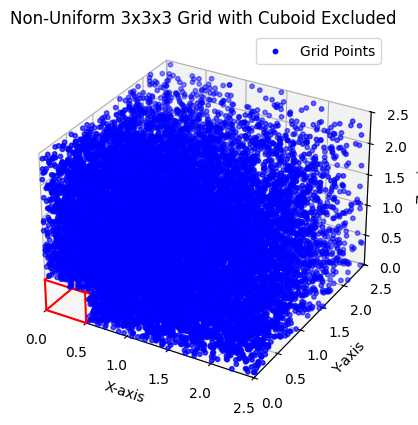

Calculating analytical B-field
Calculating demag B-field
Calculating reduced field


In [41]:
data = simulate_demag(1, 1, (0, 0, 0.5), 26, display=True, points="random")

grid = data["grid"]
length = len(grid)

X = torch.from_numpy(np.vstack(
    (
        np.ones(length) * data["a"],
        np.ones(length) * data["b"],
        np.ones(length) * data["chi_x"],
        np.ones(length) * data["chi_y"],
        np.ones(length) * data["chi_z"],
        grid[:, 0] / data["a"],
        grid[:, 1] / data["b"],
        grid[:, 2],
    )
).T).to(torch.float64)

# get the corresponding labels
B_target = torch.from_numpy(np.concatenate(
    (data["grid_field"], data["grid_field_reduced"]),
    axis=1,
)).to(torch.float64)

In [42]:
model = AngleAmpCorrectionNetwork.load_from_path("/Users/jacksmith/Documents/PhD/nn-magnetics/results/3dof_chi_random/2025-02-19 14:37:58.624918/best_weights.pt", 6)

In [43]:
B_demag, B_reduced = B_target[..., :3], B_target[...,3:]

preds = model(X)
B_corrected = model.correct_ansatz(B_reduced, preds)

In [44]:
# amp_err_field = relative_amplitude_error(B_true, B_prediction_field, return_abs=True)
# angle_err_field = angle_error(B_true, B_prediction_field)

In [45]:
amp_err_rotation = relative_amplitude_error(B_demag, B_corrected, return_abs=True).detach().numpy()
angle_err_rotation = angle_error(B_demag, B_corrected).detach().numpy()

In [46]:
amp_err_ana = relative_amplitude_error(B_demag, B_reduced, return_abs=True).detach().numpy()
angle_err_ana = angle_error(B_demag, B_reduced).detach().numpy()

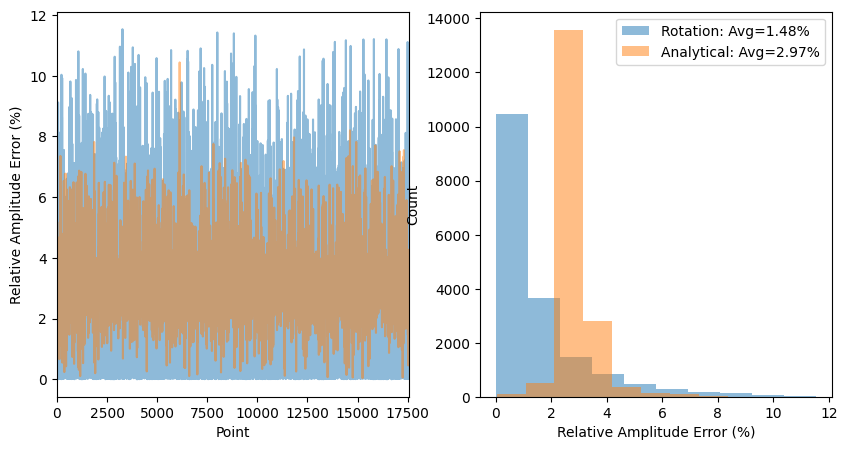

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.plot(amp_err_rotation, alpha=0.5)
# ax1.plot(amp_err_field, alpha=0.5)
ax1.plot(amp_err_ana, alpha=0.5)
ax1.set_ylabel("Relative Amplitude Error (%)")
ax1.set_xlabel("Point")
ax1.set_xlim((0, grid.shape[0]))

ax2.hist(amp_err_rotation, label=f"Rotation: Avg={round(float(np.mean(amp_err_rotation)), 2)}%", alpha=0.5)
# ax2.hist(amp_err_field, label=f"Component: Avg={round(float(np.mean(amp_err_field)), 2)}%", alpha=0.5)
ax2.hist(amp_err_ana, label=f"Analytical: Avg={round(float(np.mean(amp_err_ana)), 2)}%", alpha=0.5)
ax2.set_xlabel("Relative Amplitude Error (%)")
ax2.set_ylabel("Count")
ax2.legend()
plt.show()

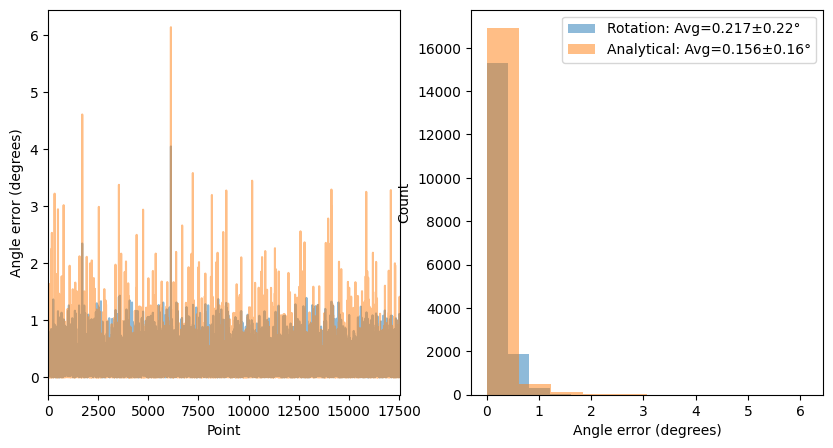

In [48]:

# angle_mean_field = round(float(np.mean(angle_err_field, where=~np.isnan(angle_err_field))), 3)
# angle_std_field = round(float(np.std(angle_err_field, where=~np.isnan(angle_err_field))), 2)

angle_mean_rotation = round(float(np.mean(angle_err_rotation, where=~np.isnan(angle_err_rotation))), 3)
angle_std_rotation = round(float(np.mean(angle_err_rotation, where=~np.isnan(angle_err_rotation))), 2)

angle_mean_ana = round(float(np.mean(angle_err_ana, where=~np.isnan(angle_err_ana))), 3)
angle_std_ana = round(float(np.mean(angle_err_ana, where=~np.isnan(angle_err_ana))), 2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.plot(angle_err_rotation, alpha=0.5)
# ax1.plot(angle_err_field, alpha=0.5)
ax1.plot(angle_err_ana,alpha=0.5)
ax1.set_ylabel("Angle error (degrees)")
ax1.set_xlabel("Point")
ax1.set_xlim((0, grid.shape[0]))

ax2.hist(angle_err_rotation, bins=10, label=f"Rotation: Avg={angle_mean_rotation}±{angle_std_rotation}°", alpha=0.5)
# ax2.hist(angle_err_field, bins=10, label=f"Component: Avg={angle_mean_field}±{angle_std_field}°", alpha=0.5)
ax2.hist(angle_err_ana, bins=10, label=f"Analytical: Avg={angle_mean_ana}±{angle_std_ana}°", alpha=0.5)
ax2.set_xlabel("Angle error (degrees)")
ax2.set_ylabel("Count")
ax2.legend()
plt.show()